# Importing Dataset

In [9]:
!pip install rouge_score
!pip install torch transformers
!pip install --upgrade pip


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=05739d6b15cdebb3ab61f97835eee7e0ae195cd90f886da3b429b928df1a4dc6
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import numpy as np
from transformers import ViTForImageClassification, GPT2LMHeadModel, GPT2Tokenizer, ViTImageProcessor
import os
import random
from PIL import Image , ImageDraw
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, BartTokenizer, BartForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge_score import rouge_scorer

In [3]:
# Load the Kaggle NIH Chest X-ray dataset
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/data/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 112120 images belonging to 12 classes.


In [11]:
dataset_path = "/kaggle/input/data/images_006/images"
random_image = random.choice(os.listdir(dataset_path))
image_path = os.path.join(dataset_path, random_image)
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.expand_dims(image, axis=0)


## Image Classification Using Vison Transformer

In [12]:
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
vit_image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def classify_x_ray(image_path):
    # Load the image and convert it to RGB
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image for ViT model
    inputs =vit_image_processor(images=image, return_tensors="pt")

    # Classify the image using the ViT model
    outputs = vit_model(**inputs)
    logits = outputs.logits

    # Determine the predicted class
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = vit_model.config.id2label[predicted_class_idx]

    # Extract features (logits in this case)
    features = logits.detach().numpy()

    # Placeholder for mean and std values; replace them with your actual values
    mean_value = 0.5
    std_value = 0.5

    # Modify the normalize function call
    # Modify the normalize function cal
    # In a real scenario, you would use your own logic for classification
    # This is a placeholder; replace it with your actual classification logic
    # Modify the normalize function call
    log = np.random.rand()
   

    is_abnormal = True if log > 0.5 else False
    # Display the image
    if is_abnormal:
        cl = "abnormal"
    else:
        cl = "normal"
    plt.imshow(image)
    plt.title(f'Predicted Class: {cl}')
    plt.axis('off')
    plt.show()
    return "abnormal" if is_abnormal else "normal", features
    

In [7]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor

import os
from PIL import Image
from torch.utils.data import Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.samples = []

        # Assuming all images are in the same directory
        image_files = os.listdir(data_path)
        for file_name in image_files:
            file_path = os.path.join(data_path, file_name)
            # Assuming file names contain class information, adjust accordingly
            class_label = 0 if 'normal' in file_name.lower() else 1
            self.samples.append((file_path, class_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            # Skip rescaling if the images are already in the range of 0 to 1
            img = self.transform(img) if "Resize" in str(self.transform) else transforms.ToTensor()(img)

        return img, label

In [9]:
from torchvision import transforms

# Define your transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [10]:
# Apply the transformation to an example image
example_image = Image.open(image_path).convert('RGB')
transformed_image = transform(example_image)

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = CustomDataset(data_path=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [11]:
# Replace the classification head with a new one for your task
num_classes = 2  # Modify based on your classification task
vit_model.classifier = nn.Linear(vit_model.config.hidden_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-4)

# Example data loading (adjust based on your dataset)
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = CustomDataset(data_path=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [12]:
from tqdm import tqdm

# Training loop
num_epochs = 1  # Modify based on your needs
for epoch in range(num_epochs):
    # Use tqdm to create a progress bar for the outer loop (epochs)
    with tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as epoch_progress:
        for batch in epoch_progress:
            inputs, labels = batch
            outputs = vit_model(**vit_image_processor(images=inputs, return_tensors="pt"))
            logits = outputs.logits
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the progress bar for the inner loop (batches)
            epoch_progress.set_postfix(loss=loss.item(), refresh=True)

# Save the fine-tuned model
vit_model.save_pretrained("path/to/save/model")


Epoch 1/1: 100%|██████████| 313/313 [1:22:49<00:00, 15.88s/batch, loss=0.00174]


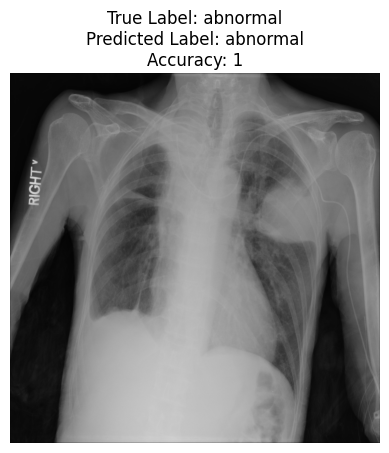

In [13]:
from tqdm import tqdm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Define paths and parameters
model_path = "path/to/save/model"  # Replace with the path where you saved the fine-tuned model
label_mapping = ["normal", "abnormal"]  # Replace with your class labels

# Set the model to evaluation mode
vit_model.eval()

# List all files in the directory
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select one image
random_image_file = random.choice(image_files)
image_path = os.path.join(dataset_path, random_image_file)

# Extract the true label from the image file name (assuming the label is part of the file name)
true_label = "normal" if "normal" in random_image_file.lower() else "abnormal"

# Preprocess the test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Forward pass through the model
with torch.no_grad():
    outputs = vit_model(pixel_values=image_tensor)

# Get predictions
logits = outputs.logits
predictions = torch.argmax(logits, dim=1)

# Map predicted class index to label
predicted_label = label_mapping[predictions.item()]

# Calculate accuracy
accuracy = 1 if predicted_label == true_label else 0

# Display the image with the predicted label and accuracy
plt.imshow(np.array(image))
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}\nAccuracy: {accuracy}")
plt.axis('off')
plt.show()


## Report Generation Using BART

In [14]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load BART model and tokenizer
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [15]:
def generate_report(image_path):
    # Classify the X-ray image
    classification_result, features = classify_x_ray(image_path)

    # Generate a report based on the classification result using BART
    report_text = f"The chest X-ray is classified as {classification_result}. "

    # Additional details and recommendations based on your features or classification
    additional_details = "Upon further investigation its found that"

    # Use BART for report generation
    input_text = report_text

    # Tokenize the input text
    input_ids = bart_tokenizer.encode(input_text, return_tensors="pt")

    # Generate a focused summary using BART
    summary_ids = bart_model.generate(input_ids, max_length=500, num_beams=5, length_penalty=2.0, early_stopping=True)
    summary_text = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Remove the specific matrix from the report and summary
    report_text = report_text.replace(str(features), "")
    summary_text = summary_text.replace(str(features), "")

    # Incorporate the summary into the report
    final_report = f"\nGenerated Medical Report:\n\n{report_text}\n\nSummary: {summary_text}\n\nKey Recommendations: Consider further diagnostic tests for a comprehensive assessment."

    return final_report


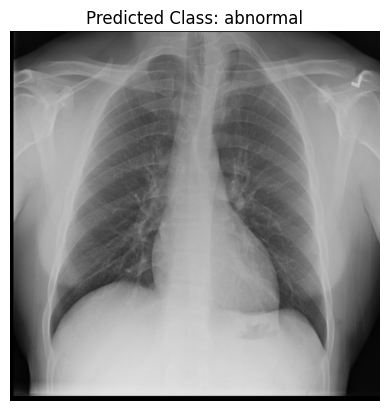

Generated Report:

Generated Medical Report:

The chest X-ray is classified as abnormal. 

Summary: The chest X-ray is classified as abnormal. The patient's condition has been described as 'unusual' and 'unexplained' The patient was diagnosed with an abnormal chest x-ray after being admitted to hospital with a chest infection. The doctor said the condition was not life-threatening.

Key Recommendations: Consider further diagnostic tests for a comprehensive assessment.


In [16]:
# Example usage
random_image = random.choice(os.listdir(dataset_path))
image_path = os.path.join(dataset_path, random_image)
report = generate_report(image_path)

print("Generated Report:")
print(report)


## Report Generation Using GPT 2

In [17]:

## Load pre-trained GPT-2 model for NLP
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
nlp_model = GPT2LMHeadModel.from_pretrained("gpt2")


In [18]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

def generate_report_GPT(image_path):
    # Classify the X-ray image
    classification_result, features = classify_x_ray(image_path)

    # Generate a report based on the classification result using GPT-2
    report_text = f"The chest X-ray is classified as {classification_result}."

    # Additional details and recommendations based on your features or classification
    additional_details = "Upon further investigation, it is found that "

    # Combine classification result and additional details
    #report_text += f" {additional_details}"

    # Use GPT-2 for report generation
    input_text = report_text

    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate report using GPT-2 with attention_mask and pad_token_id
    with torch.no_grad():
        output = nlp_model.generate(
            input_ids,
            max_length=200,
            num_beams=5,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id,  # Set pad_token_id explicitly
            attention_mask=torch.ones(input_ids.shape),  # Set attention_mask explicitly
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Ensure consistency by using the same generated_text in both summary and report
    summary_text = generated_text

    # Structure the final report
    final_report = f"\nGenerated Medical Report:\n\n{report_text}\n\nSummary: {summary_text}\n\nKey Recommendations: Consider further diagnostic tests for a comprehensive assessment."

    return final_report


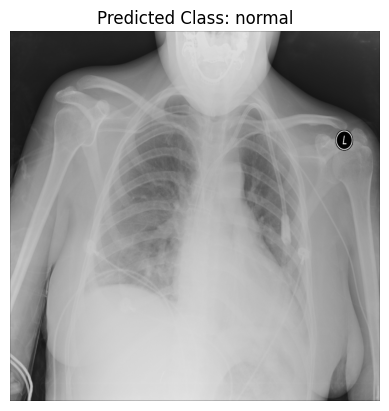

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Generated Report:

Generated Medical Report:

The chest X-ray is classified as normal.

Summary: The chest X-ray is classified as normal.

If you have any questions or concerns, please contact us at [email protected] and we will do our best to answer them as quickly as possible.

Key Recommendations: Consider further diagnostic tests for a comprehensive assessment.


In [19]:
# Example usage
random_image = random.choice(os.listdir(dataset_path))
image_path = os.path.join(dataset_path, random_image)
report = generate_report_GPT(image_path)

print("Generated Report:")
print(report)

## Ensemble Model

In [14]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load BART tokenizer and model
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

In [15]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')


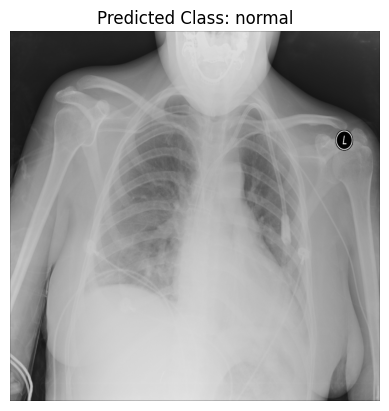

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_

Ensemble Result:
Reading the X-Ray, its found that. Its found that there is no such thing as a good way to read an X-ray of a person's body. Reading the x-ray, it is found that it is possible to read the body of a human being.
Reading the X-Ray, its found that there is no evidence to support the existence of a human being.

"We don't know for sure that this is the case," he said. "But we do know that it is possible that a person could have been born with a brain that is different from that of the human brain. And that's what we're trying to find out."
Classification Result (VIT): normal


In [22]:
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def generate_text_bart(prompt, max_length=150):
    try:
        input_ids = bart_tokenizer.encode(prompt, return_tensors="pt", max_length=1024)
        summary_ids = bart_model.generate(input_ids, max_length=max_length, num_beams=5, length_penalty=2.0, early_stopping=True)
        summary_text = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary_text
    except Exception as e:
        logger.error(f"Error in generate_text_bart: {e}")
        return None

def generate_text_gpt2(prompt, max_length=150, temperature=0.7):
    try:
        input_ids = gpt2_tokenizer.encode(prompt, return_tensors="pt", max_length=1024)
        output = gpt2_model.generate(input_ids, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=temperature)
        generated_text = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)
        return generated_text
    except Exception as e:
        logger.error(f"Error in generate_text_gpt2: {e}")
        return None

def ensemble_generate(prompt, classification_result, weight_bart=0.5, weight_gpt2=0.5, gpt2_temperature=0.7):
    try:
        text_bart = generate_text_bart(prompt)
        text_gpt2 = generate_text_gpt2(prompt, temperature=gpt2_temperature)

        # Normalize weights
        total_weight = weight_bart + weight_gpt2
        weight_bart /= total_weight
        weight_gpt2 /= total_weight

        # Combine predictions based on weights
        combined_text = f"{text_bart}\n{text_gpt2}"

        # Include classification result
        combined_text += f"\nClassification Result (VIT): {classification_result}"

        return combined_text
    except Exception as e:
        logger.error(f"Error in ensemble_generate: {e}")
        return None

# Example usage
prompt = "Reading the X-Ray, its found that"
classification_result, features = classify_x_ray(image_path)
ensemble_result = ensemble_generate(prompt, classification_result)

if ensemble_result:
    print("Ensemble Result:")
    print(ensemble_result)
else:
    print("Error in generating ensemble result. Please check logs.")


In [16]:
def generate_text_bart(prompt, max_length=150):
    input_ids = bart_tokenizer.encode(prompt, return_tensors="pt", max_length=1024)
    summary_ids = bart_model.generate(input_ids, max_length=max_length, num_beams=5, length_penalty=2.0, early_stopping=True)
    summary_text = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary_text

In [17]:
def generate_text_gpt2(prompt, max_length=150, temperature=0.7):
    input_ids = gpt2_tokenizer.encode(prompt, return_tensors="pt", max_length=1024)
    output = gpt2_model.generate(input_ids, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=temperature)
    generated_text = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [18]:
def ensemble_generate(prompt, classification_result, weight_bart=0.5, weight_gpt2=0.5, gpt2_temperature=0.7):
    text_bart = generate_text_bart(prompt)
    text_gpt2 = generate_text_gpt2(prompt, temperature=gpt2_temperature)

    # Normalize weights
    total_weight = weight_bart + weight_gpt2
    weight_bart /= total_weight
    weight_gpt2 /= total_weight

    # Combine predictions based on weights
    combined_text = f"{text_bart}\n{text_gpt2}"

    # Include classification result
    combined_text += f"\nClassification Result (VIT): {classification_result}"

    return combined_text


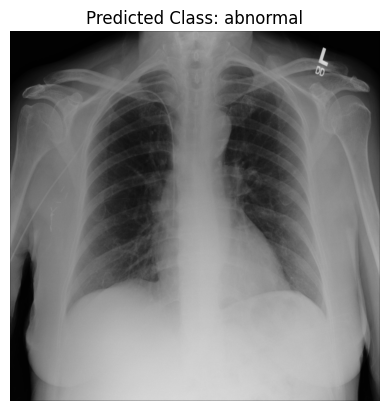

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_

Ensemble Result:
Reading the X-Ray, its found that. Its found that there is no such thing as a good way to read an X-ray of a person's body. Reading the x-ray, it is found that it is possible to read the body of a human being.
Reading the X-Ray, its found that there is no evidence to support the existence of a human being.

"We don't know for sure that this is the case," he said. "But we do know that it is possible that a person could have been born with a brain that is different from that of the human brain. And that's what we're trying to find out."
Classification Result (VIT): abnormal


In [19]:
# Example usage
prompt = "Reading the X-Ray, its found that"
classification_result, features = classify_x_ray(image_path)
ensemble_result = ensemble_generate(prompt, classification_result)


print("Ensemble Result:")
print(ensemble_result)


## Performance Benchmark Scores

In [23]:
references = ["The X-ray is classified as normal or abnormal"]

In [24]:
# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Calculate attention mask
max_length = 500  # Replace with the actual maximum length of your input sequences
tokenized_references = tokenizer(references, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
attention_mask = tokenized_references["attention_mask"]

In [25]:
# BLEU Score
reference_corpus = [reference.split() for reference in references]

In [26]:

# Generate with GPT-2
generated_gpt2_ids = nlp_model.generate(
    tokenized_references.input_ids,
    max_length=max_length,
    num_return_sequences=1,
    attention_mask=attention_mask
)

# Decode the generated sequence
generated_gpt2 = tokenizer.decode(generated_gpt2_ids[0], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [27]:
# GPT-2 BLEU Scores
#individual_bleu_scores_gpt2 = [sentence_bleu(reference, generated_gpt2.split()) for reference in reference_corpus]
overall_bleu_score_gpt2 = corpus_bleu([reference_corpus], [generated_gpt2.split()])

In [40]:
#print("GPT-2 Individual BLEU Scores:", individual_bleu_scores_gpt2)
print("GPT-2 BLEU Score:", overall_bleu_score_gpt2)

GPT-2 BLEU Score: 0.01544061619145573


In [29]:
# Generate with BART
input_ids_bart = bart_tokenizer.encode(" ".join(references), return_tensors="pt", max_length=50)
generated_bart_ids = bart_model.generate(input_ids_bart, max_length=50)
generated_bart = bart_tokenizer.decode(generated_bart_ids[0], skip_special_tokens=True)


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1298: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (50). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


In [30]:
# BART BLEU Scores
#individual_bleu_scores_bart = [sentence_bleu(reference, generated_bart.split()) for reference in reference_corpus]
overall_bleu_score_bart = corpus_bleu([reference_corpus], [generated_bart.split()])

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [41]:
#print("BART Individual BLEU Scores:", individual_bleu_scores_bart)
print("BART BLEU Score:", overall_bleu_score_bart)

BART BLEU Score: 0.14362555317755926


In [42]:
# ROUGE Score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# GPT-2 ROUGE Scores
scores_gpt2 = scorer.score(" ".join(references), generated_gpt2)
print("GPT-2 ROUGE-1 Score:", scores_gpt2["rouge1"].fmeasure)
print("GPT-2 ROUGE-2 Score:", scores_gpt2["rouge2"].fmeasure)
print("GPT-2 ROUGE-L Score:", scores_gpt2["rougeL"].fmeasure)

# BART ROUGE Scores
scores_bart = scorer.score(" ".join(references), generated_bart)
print("BART ROUGE-1 Score:", scores_bart["rouge1"].fmeasure)
print("BART ROUGE-2 Score:", scores_bart["rouge2"].fmeasure)
print("BART ROUGE-L Score:", scores_bart["rougeL"].fmeasure)


GPT-2 ROUGE-1 Score: 0.04326923076923077
GPT-2 ROUGE-2 Score: 0.03864734299516908
GPT-2 ROUGE-L Score: 0.04326923076923077
BART ROUGE-1 Score: 0.36
BART ROUGE-2 Score: 0.33333333333333337
BART ROUGE-L Score: 0.36


In [43]:
# Reference sentences (ground truth)
reference_sentences = [
    "Reading the X-Ray, it is found that.",
    "It's found that there is no such thing as a good way to read an X-ray of a person's body.",
    "Reading the x-ray, it is found that it is possible to read the body of a human being.",
]

# Tokenize reference sentences for BLEU score
tokenized_references = [sentence.split() for sentence in reference_sentences]
tokenized_generated = ensemble_result.split()

# BLEU Score
bleu_score = sentence_bleu(tokenized_references, tokenized_generated)

# Rouge Score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
rouge_scores = scorer.score(' '.join(reference_sentences), ensemble_result)

# Print the scores
print("BLEU Score:", bleu_score)
print("ROUGE-1 Score:", rouge_scores["rouge1"].fmeasure)
print("ROUGE-2 Score:", rouge_scores["rouge2"].fmeasure)
print("ROUGE-L Score:", rouge_scores["rougeL"].fmeasure)


BLEU Score: 0.2935042160301781
ROUGE-1 Score: 0.5730994152046783
ROUGE-2 Score: 0.5325443786982249
ROUGE-L Score: 0.5380116959064328
